In this kernel, we will explore the complete workflow for the APTOS 2019 competition. We will go through:

1. Loading & Exploration: A quick overview of the dataset
2. Resize Images: We will resize both the training and test images to 224x224, so that it matches the ImageNet format.
3. Mixup & Data Generator: We show how to create a data generator that will perform random transformation to our datasets (flip vertically/horizontally, rotation, zooming). This will help our model generalize better to the data, since it is fairly small (only ~3000 images).
4. Quadratic Weighted Kappa: A thorough overview of the metric used for this competition, with an intuitive example. Check it out!
5. Model: We will use a DenseNet-121 pre-trained on ImageNet. We will finetune it using Adam for 15 epochs, and evaluate it on an unseen validation set.
6. Training & Evaluation: We take a look at the change in loss and QWK score through the epochs.

### Citations & Resources

* I had the idea of using mixup from [KeepLearning's ResNet50 baseline](https://www.kaggle.com/mathormad/aptos-resnet50-baseline). Since the implementation was in PyTorch, I instead used an [open-sourced keras implementation](https://github.com/yu4u/mixup-generator).
* The transfer learning procedure is mostly inspired from my [previous kernel for iWildCam](https://www.kaggle.com/xhlulu/densenet-transfer-learning-iwildcam-2019). The workflow was however heavily modified since then.
* Used similar [method as Abhishek](https://www.kaggle.com/abhishek/optimizer-for-quadratic-weighted-kappa) to find the optimal threshold.
* [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets) prompted me to try using Multilabel instead of multiclass classification, which slightly improved the kappa score.

In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

Using TensorFlow backend.


# Loading & Exploration

In [2]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
print(train_df.shape)
print(test_df.shape)

(3662, 2)
(1928, 1)


In [3]:
def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    return im

In [56]:
def load_ben_color(path, size, sigmaX=10 ):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = crop_image_from_gray(image)
    image = cv2.resize(image, (size, size))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    return image

def load_ben_gray(path, size):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (size, size))
    image = cv2.addWeighted(
       image, 4, cv2.GaussianBlur(image, (0, 0), size / 10), -4, 128
    )  # Ben Graham's preprocessing method [1]
    ## (IMG_SIZE, IMG_SIZE) -> (IMG_SIZE, IMG_SIZE, 3)
    image = image.reshape(size, size, 1)
    image = np.repeat(image, 3, axis=-1)
    return image

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [37]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = np.load(
        f'../data/train_images/npy_bengrahm/{image_id}.npy'
    )

100%|██████████| 3662/3662 [00:05<00:00, 717.39it/s] 


In [57]:
N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = load_ben_gray(
        f'../data/test_images/{image_id}.png', 224
    )

100%|██████████| 1928/1928 [01:12<00:00, 26.70it/s]


In [6]:
#!mkdir ../data/npy_files
#np.save('../data/npy_files/x_train.npy', x_train)

In [38]:
#x_train = np.load('../data/npy_files/x_train.npy')
#x_test = np.load('../data/npy_files/x_test.npy')

In [39]:
y_train = pd.get_dummies(train_df['diagnosis']).values
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(3662, 224, 224, 3)
(3662, 5)
(1928, 224, 224, 3)


## Creating multilabels

Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. For more details, please check out [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets).

In [40]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [41]:
x_train.shape, y_train_multi.shape

((3662, 224, 224, 3), (3662, 5))

In [42]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=0.15, 
    random_state=2019
)

# Mixup & Data Generator

In [43]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [44]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE)
# Using Mixup
mixup_generator = MixupGenerator(x_train, y_train, batch_size=BATCH_SIZE, alpha=0.2, datagen=create_datagen())()

### Creating keras callback for QWK

In [45]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5 # <<<<<<<<<<<<<<<<<<<
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

# Model: DenseNet-121

In [46]:
densenet = DenseNet121(
    include_top=False,
    input_shape=(224,224,3)
)

In [47]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [48]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


# Training & Evaluation

In [49]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)

Epoch 1/30
98/97 [==============================] - 48s 488ms/step - loss: 0.5036 - acc: 0.7586 - val_loss: 0.3089 - val_acc: 0.8571
val_kappa: 0.7732
Validation Kappa has improved. Saving model.
Epoch 2/30
98/97 [==============================] - 27s 278ms/step - loss: 0.2259 - acc: 0.9129 - val_loss: 0.1780 - val_acc: 0.9382
val_kappa: 0.8212
Validation Kappa has improved. Saving model.
Epoch 3/30
98/97 [==============================] - 27s 278ms/step - loss: 0.1791 - acc: 0.9290 - val_loss: 0.2102 - val_acc: 0.9207
val_kappa: 0.7490
Epoch 4/30
98/97 [==============================] - 27s 279ms/step - loss: 0.1636 - acc: 0.9372 - val_loss: 0.1744 - val_acc: 0.9320
val_kappa: 0.8082
Epoch 5/30
98/97 [==============================] - 27s 279ms/step - loss: 0.1418 - acc: 0.9444 - val_loss: 0.1268 - val_acc: 0.9513
val_kappa: 0.8780
Validation Kappa has improved. Saving model.
Epoch 6/30
98/97 [==============================] - 27s 279ms/step - loss: 0.1375 - acc: 0.9467 - val_loss: 0.

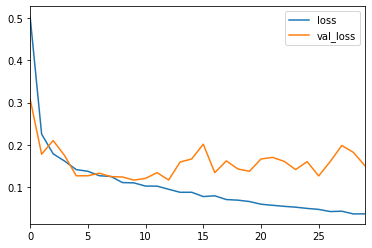

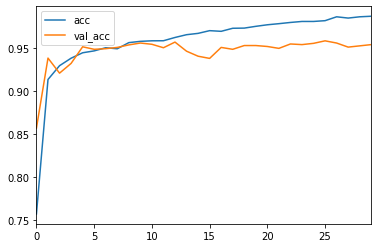

In [50]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

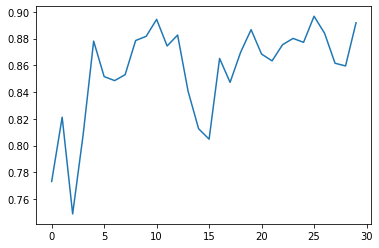

In [51]:
plt.plot(kappa_metrics.val_kappas)

# LOAD test set with  bengrahm preprocessing ffs, before final prediction 

In [58]:
model.load_weights('model_bengrahm.h5')
y_val_pred = model.predict(x_val)

def compute_score_inv(threshold):
    y1 = y_val_pred > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')
    
    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 0.5, method='nelder-mead'
)

best_threshold = simplex['x'][0]
best_threshold

In [59]:
#best_threshold = 0.45
best_threshold

0.5

## Submit

In [64]:
y_test = model.predict(x_test) > 0.65
y_test = y_test.astype(int).sum(axis=1) - 1

np.unique(y_test, return_counts=True)
# test_df['diagnosis'] = y_test
# test_df.to_csv('submission.csv',index=False)

(array([0, 1, 2, 3, 4]), array([ 369,  259, 1068,  168,   64]))